In [1]:
import pandas as pd

from rdkit import Chem, DataStructs
from rdkit.Chem import rdmolops, rdMolAlign
from rdkit.Chem import Draw, rdFMCS, AllChem, rdmolfiles, Descriptors, rdchem, rdMolDescriptors, rdmolops, rdFMCS
from rdkit.Chem.AtomPairs import Pairs
from rdkit.Chem import Draw

from rdkit.Chem.Draw import IPythonConsole

from IPython.display import display
from IPython.display import SVG,Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

Objective: 
- Generate a list of ligand endpoints that represent a range of 'difficult' FEPs
- Depict these endpoints
- Per pair of ligands, generate an intermediate
- Depict all triplets (i.e. endpoints + intermediate)
- Compute some difficulty metric (e.g. LOMAP-Score) per triplet for A->B and A->i->B

In [2]:
# load selfies interpolator. See https://github.com/JenkeScheen/stoned-selfies/blob/main/sandbox/gen_intermediates.ipynb
from interpolate_selfies_restrained import *

In [3]:

# interpolation settings.
num_tries             = 6
num_random_samples    = 6
collect_bidirectional = False # Doubles the number of paths: source->target & target->source
apply_filter          = False
num_top_iter          = 4    # Number of molecules that are selected after each iteration

In [4]:
# set perts to investigate in this list. make sure tgt/ligand names are correct because these strings are used to 
# parse ./ligands/.

perts_to_intrap = [
    ["tyk2", "ejm_54~ejm_31"], # start with a few easy FEPs.
    ["tyk2", "ejm_42~ejm_44"],
    ["tyk2", "ejm_44~ejm_31"],
    
    ["tyk2", "jmc_27~ejm_54"], # now try a few ring jumps.
    ["tyk2", "ejm_43~ejm_47"],
    ["tyk2", "ejm_49~ejm_45"],
    ["tnks2", "5p~5m"],
    ["tnks2", "1b~3a"],
    
    ["tnks2", "1a~8a"], # charge jumps probably out of scope.
    
    ["eg5", "CHEMBL1084678~CHEMBL1085666"], # some challenging multi-R-group ones.
    ["eg5", "CHEMBL1077227~CHEMBL1096002"], 
    ["eg5", "CHEMBL1082249~CHEMBL1085666"],
    
    ["galectin", "07_ligOH~05_ligOEt"], # tests a large MCS
    
    ["cats", "CatS_165~CatS_132"],  # also large MCS, but also large transform.
    ["cats", "CatS_29~CatS_141"], # mostly interested in seeing what happens to sulfoxide
    ["jnk1", "18635-1~18636-1"], # another MCS check. This transformation is already as 'small as can be'
    ["jnk1", "18627-1~18625-1"], # what if the transformation is already small as can be; but also just para->ortho?
    ["jnk1", "18634-1~18659-1"], # together with next; do both directions (A->B/B->A) result in same intermediate?
    ["jnk1", "18659-1~18634-1"]
                ]

In [5]:
def generateIntermediate(lig_1, lig_2):

    smi_1 = Chem.MolToSmiles(lig_1)

    smi_2 = Chem.MolToSmiles(lig_2)

    # get medians between lambdas.
    smiles = interpolate_selfies(smi_1, smi_2, num_samples=10)
    
    # get the best median based on the supplied change_score.
    top_median = min(smiles, key = smiles.get)

    return Chem.MolFromSmiles(top_median)

In [6]:

def alignLigands(liga, intermediate, ligb):
    """Given a triplet of ligands; align to the first ligand such that we can more easily view differences.
    All ligand manipulations are done in-place."""
    # NB: when actual intermediates are being generated; include the intermediate in the MCS detection and
    # in the alignment!
    
    template = Chem.MolFromSmarts(rdFMCS.FindMCS([liga, intermediate, ligb],
                                    atomCompare=rdFMCS.AtomCompare.CompareAny,
                                    bondCompare=rdFMCS.BondCompare.CompareAny,
                                    matchValences=False,
                                    ringMatchesRingOnly=True,
                                    completeRingsOnly=True,
                                    matchChiralTag=False,
                                    timeout=2).smartsString) # need to set timeout because for some scaffolds the MCS
                                                             # can take minutes.
    AllChem.Compute2DCoords(template)
    
    for lig in [liga, intermediate, ligb]:
        # align.
        AllChem.GenerateDepictionMatching2DStructure(lig, template)
        # Remove stereochemistry to simplify depiction in network.
        rdmolops.RemoveStereochemistry(lig)
    
    return liga, intermediate, ligb

In [7]:
def getMolImg(mol):
    """Saves a molecule image and loads it back in and returns it. Allows viewing RDKit molecules during 
    loop iterations. """

    Draw.MolToFile(mol, "plt_workdir/tmp.png")
    img = mpimg.imread("plt_workdir/tmp.png")
    
    return img    

In [8]:
def depictMolTriplet(liga, intermediate, ligb, tgt, pert_name, time_taken):
    """given three molecular inputs, plot a graph of each, side-by-side."""
    
    # get img objects for each lig
    img0 = getMolImg(liga)
    img1 = getMolImg(intermediate)
    img2 = getMolImg(ligb)

    # now plot.
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1, 1]})

    axes[0].imshow(img0)
    axes[1].imshow(img1)
    axes[2].imshow(img2)

    # turn off axes and set titles.
    titles = ["$\lambda = 0$", "Intermediate", "$\lambda = 1$"]
    for ax, title in zip(axes, titles):
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        ax.set_title(title)

    # annotate the left-hand side plot with the perturbation name instead of y axis label.
    axes[0].text(-0.05, 0.5*(0.25+0.75), f"{tgt.upper()}: {pert_name}",
        horizontalalignment='right',
        verticalalignment='center',
        rotation='vertical',
        transform=axes[0].transAxes)
    
    # annotate walltime.
    axes[2].annotate(time_taken, xy=(0.6, 0.9), xycoords="axes fraction", size=16)
    
    plt.show()

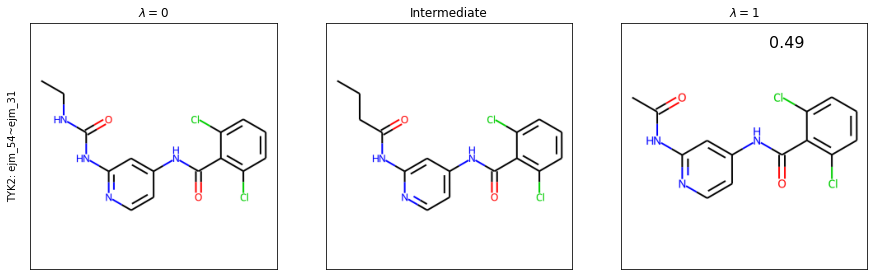

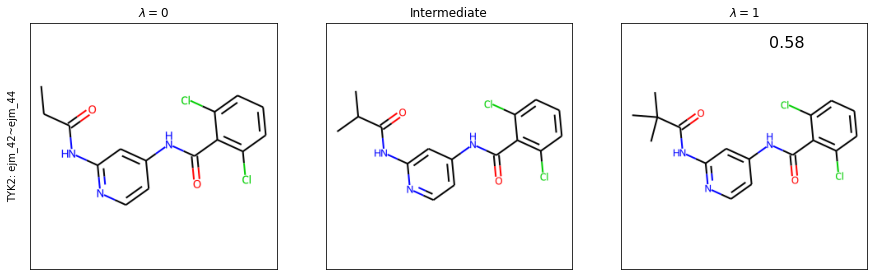

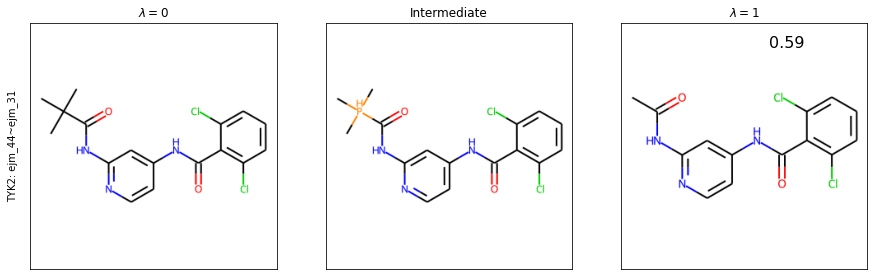

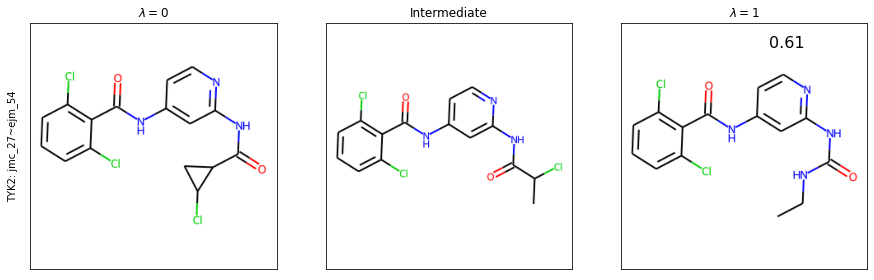

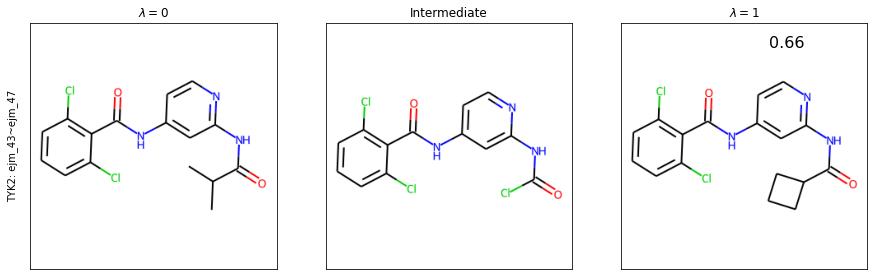

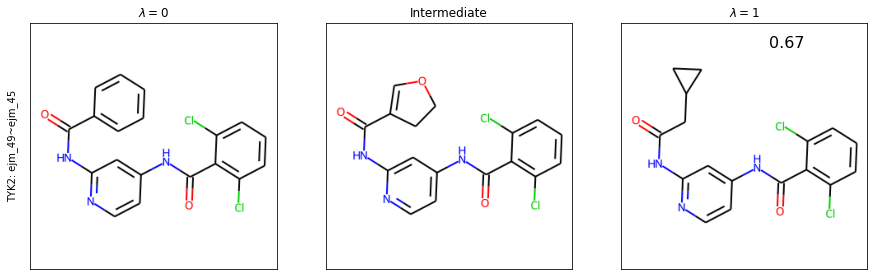

In [ ]:
for tgt, pert in perts_to_intrap:
    first_stamp = int(round(time.time() * 1000))
    
    # get the endpoint molecular objects.
    liga, ligb = pert.split("~")
    try:
        liga, ligb = [ Chem.rdmolfiles.SDMolSupplier(f"ligands/{tgt}/{lig}.sdf")[0] for lig in [liga, ligb]]
    except OSError:
        # naming is inconsistent; try with 'lig_' prefix.
        liga, ligb = [ Chem.rdmolfiles.SDMolSupplier(f"ligands/{tgt}/lig_{lig}.sdf")[0] for lig in [liga, ligb]]

    # generate the intermediate.
    intermediate = generateIntermediate(liga, ligb) 
    
    # align everything. 
    liga, intermediate, ligb = alignLigands(liga, intermediate, ligb)
    
    # Calculate the time taken in minutes
    second_stamp = int(round(time.time() * 1000))
    time_taken = round((second_stamp - first_stamp)/1000/60, 2)
    
    depictMolTriplet(liga, intermediate, ligb, tgt, pert, time_taken)    
